In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, explode, split, udf, regexp_replace
from pyspark.sql.types import IntegerType
import time
import pandas as pd

chunk_amounts = [50]
iterations = 1
executor_cores_options = [2]

# Prepare to collect results
results = []

# Lists of positive and negative words for simple sentiment analysis
negative_words = set([
    "sad", "pain", "suffer", "problem", "fail", "negative", "angry", "bad", "catastrophe", "dangerous",
    "evil", "frustrate", "grim", "harmful", "ignorant", "jealous", "kill", "loss", "miserable", "nasty",
    "obstacle", "pathetic", "quit", "ruinous", "scary", "terrible", "upset", "vicious", "war", "xenophobia",
    "yucky", "zero", "abandon", "brutal", "cruel", "depressing", "enraged", "filthy", "ghastly", "horrible",
    "ill", "jarring", "knocked", "lethal", "malicious", "nauseous", "offensive", "poisonous", "quandary",
    "repulsive", "sickening", "tragic", "unfortunate", "violent", "wrathful", "anxious", "bleak", "clumsy",
    "despair", "embarrass", "flawed", "guilty", "harsh", "insecure", "jeopardy", "lonely", "menacing",
    "ominous", "pessimistic", "quarrelsome", "regret", "sorrow", "tense", "uneasy", "vulnerable", "worried",
    "accursed", "bitter", "cold", "detest", "eerie", "foreboding", "grudge", "hostile", "insidious", "jolt",
    "kreepy", "loathsome", "malady", "nefarious", "oppressive", "perilous", "quarantine", "revulsion",
    "spiteful", "torment", "unpleasant", "vengeful", "wicked", "xenophobic"
])

positive_words = set([
    "happy", "joy", "blessed", "fortunate", "progress", "success", "love", "wonderful", "thriving",
    "excellent", "positive", "cheerful", "delightful", "ecstatic", "glowing", "hopeful", "inspired",
    "lively", "marvelous", "optimistic", "radiant", "splendid", "vibrant", "winning", "admire",
    "brilliant", "celebrate", "dream", "empower", "fascinate", "grateful", "honor", "incredible",
    "joyous", "kind", "lucky", "magical", "noble", "outstanding", "peaceful", "quest", "rewarding",
    "spectacular", "terrific", "ultimate", "valuable", "wonderful", "youthful", "zealous", "achieve",
    "bright", "courage", "dazzling", "enthusiastic", "flourish", "generous", "harmony", "ideal",
    "jubilant", "kinship", "lavish", "mastery", "notable", "oasis", "praise", "quality", "refreshing",
    "serene", "tranquil", "uplift", "victory", "wealthy", "exuberant", "free", "graceful", "honest",
    "imaginative", "jolly", "keen", "leisure", "mirth", "nourish", "opportunity", "plentiful", "quaint",
    "resilient", "stable", "thrive", "unwavering", "vivid", "wisdom", "exquisite", "festive", "glorious",
    "hearty", "inviting", "jovial", "knightly", "luminous", "miraculous"
])


# Define a UDF to classify sentiment based on word lists
def sentiment_classification(words_list):
    positive_score = sum([word in positive_words for word in words_list])
    negative_score = sum([word in negative_words for word in words_list])
    return 1 if positive_score > negative_score else -1 if negative_score > positive_score else 0

# Register the UDF with Spark
sentiment_udf = udf(sentiment_classification, IntegerType())

for executor_cores in executor_cores_options:
    spark_session = SparkSession.builder\
        .appName("KeywordBasedSentimentAnalysis")\
        .master("spark://192.168.2.230:7077")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled", True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout", "30000s")\
        .config("spark.executor.cores", executor_cores)\
        .config("spark.driver.port", 9999)\
        .config("spark.blockManager.port", 10005)\
        .config("spark.executor.memory", "2g")\
        .getOrCreate()

    for chunks in chunk_amounts:
        for iteration in range(iterations):
            start_time = time.time()

            file_paths = [f"hdfs://master:9000/path/in/hdfs/JsonFiles/corpus-webis-shortened_chunk{i}.json" for i in range(1, chunks + 1)]
            df = spark_session.read.option("multiline", "true").json(file_paths)

            mid_time = time.time()

            # Explode content into individual words for sentiment analysis
            words_df = df.select(explode(split(lower(col("content")), "\s+")).alias("word"))
            
            # Filter out non-alphanumeric characters to ensure clean word matching
            clean_words_df = words_df.select(regexp_replace(col("word"), "[^a-zA-Z]", "").alias("word"))

            # Apply sentiment analysis based on keyword matching
            df_with_sentiment = df.withColumn("sentiment", sentiment_udf(split(lower(col("content")), "\s+")))
            positive_comments = df_with_sentiment.filter(col("sentiment") == 1).count()
            negative_comments = df_with_sentiment.filter(col("sentiment") == -1).count()

            end_time = time.time()

            load_time = mid_time - start_time
            total_time = end_time - start_time

            results.append({
                'Executor Cores': executor_cores,
                'Chunks': chunks,
                'Iteration': iteration + 1,
                'Load Time (s)': load_time,
                'Total Time (s)': total_time,
                'Positive Comments': positive_comments,
                'Negative Comments': negative_comments
            })
    
    spark_session.stop()

# Convert results to a pandas DataFrame for easy tabular display
results_df = pd.DataFrame(results)
print(results_df)


   Executor Cores  Chunks  Iteration  Load Time (s)  Total Time (s)  \
0               2      50          1       8.663131       14.180205   

   Positive Comments  Negative Comments  
0               1020               1121  


Matplotlib is building the font cache; this may take a moment.


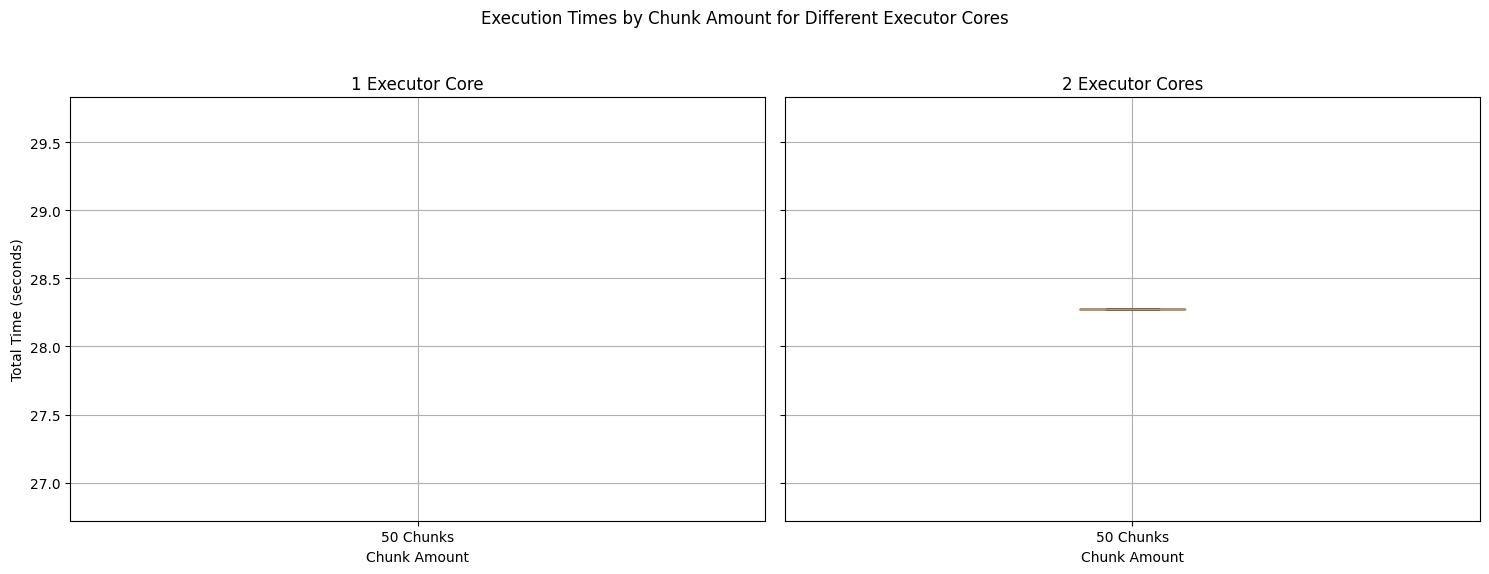

In [2]:
try:
    import matplotlib.pyplot as plt
    
    # Set up the figure and axes for the two plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
    
    # Title for the entire figure
    fig.suptitle('Execution Times by Chunk Amount for Different Executor Cores')
    
    # Plot settings for 1 executor core
    data_1_core = [results_df[(results_df['Executor Cores'] == 1) & (results_df['Chunks'] == chunks)]['Total Time (s)'] for chunks in chunk_amounts]
    axes[0].boxplot(data_1_core, labels=[f'{chunks} Chunks' for chunks in chunk_amounts])
    axes[0].set_title('1 Executor Core')
    axes[0].set_xlabel('Chunk Amount')
    axes[0].set_ylabel('Total Time (seconds)')
    axes[0].grid(True)
    
    # Plot settings for 2 executor cores
    data_2_cores = [results_df[(results_df['Executor Cores'] == 2) & (results_df['Chunks'] == chunks)]['Total Time (s)'] for chunks in chunk_amounts]
    axes[1].boxplot(data_2_cores, labels=[f'{chunks} Chunks' for chunks in chunk_amounts])
    axes[1].set_title('2 Executor Cores')
    axes[1].set_xlabel('Chunk Amount')
    axes[1].grid(True)
    
    # Use the same y-axis scale for both plots
    plt.yscale('linear')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make room for the global title
    plt.show()

    

except ImportError:
    print("matplotlib is not installed. Install it via pip to enable plotting.")

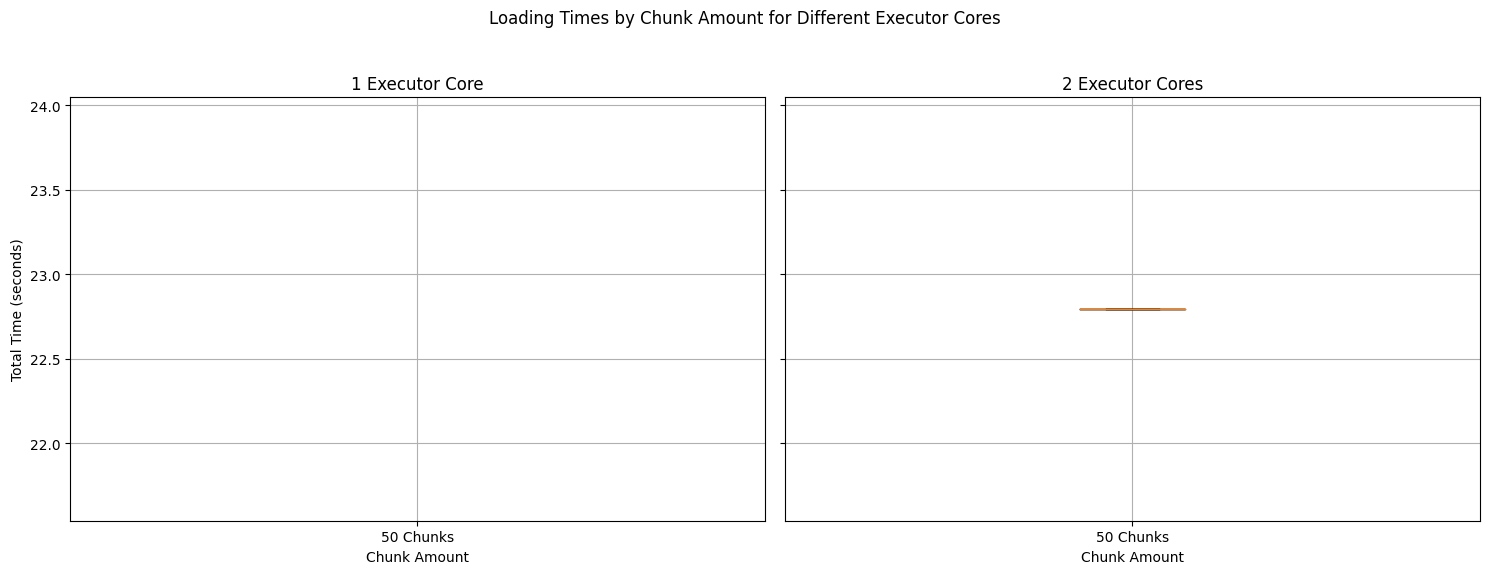

In [3]:
try:
    import matplotlib.pyplot as plt
    
    # Set up the figure and axes for the two plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
    
    # Title for the entire figure
    fig.suptitle('Loading Times by Chunk Amount for Different Executor Cores')
    
    # Plot settings for 1 executor core
    data_1_core = [results_df[(results_df['Executor Cores'] == 1) & (results_df['Chunks'] == chunks)]['Load Time (s)'] for chunks in chunk_amounts]
    axes[0].boxplot(data_1_core, labels=[f'{chunks} Chunks' for chunks in chunk_amounts])
    axes[0].set_title('1 Executor Core')
    axes[0].set_xlabel('Chunk Amount')
    axes[0].set_ylabel('Total Time (seconds)')
    axes[0].grid(True)
    
    # Plot settings for 2 executor cores
    data_2_cores = [results_df[(results_df['Executor Cores'] == 2) & (results_df['Chunks'] == chunks)]['Load Time (s)'] for chunks in chunk_amounts]
    axes[1].boxplot(data_2_cores, labels=[f'{chunks} Chunks' for chunks in chunk_amounts])
    axes[1].set_title('2 Executor Cores')
    axes[1].set_xlabel('Chunk Amount')
    axes[1].grid(True)
    
    # Use the same y-axis scale for both plots
    plt.yscale('linear')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make room for the global title
    plt.show()

    

except ImportError:
    print("matplotlib is not installed. Install it via pip to enable plotting.")